# Some cool title

#### Zack Peachell, Jasper Palov, Arjun Saxena, Bhavya Dubey

## Introduction

## Our Methods and Results

Before starting our analysis we need to load in several packages in order to have most of our functions work in the R language

In [2]:
#This cell must be run to continue
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The dataset we are using has to be read in from the repository in a relative path, so that we can start manipulating it to reach our conclusion, and to avoid any confusion associated with an absolute path.

In [3]:
star_raw_data <- "https://raw.githubusercontent.com/zackpeachell/DSCI_100_group_008_05/main/6%20class%20csv.csv"
read_star <- read_csv(star_raw_data)
read_star

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Star color, Spectral Class
dbl (5): Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3068,0.0024,0.1700,16.12,0,Red,M
3042,0.0005,0.1542,16.60,0,Red,M
2600,0.0003,0.1020,18.70,0,Red,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8829,537493,1423,-10.73,5,White,A
9235,404940,1112,-11.23,5,White,A
37882,294903,1783,-7.80,5,Blue,O


While although this dataset looks tidy, the names of the columns prove to be quite challenging to work with when in R, and therefore will be changed to remove brackets and spaces. As well we will remove any "non-applicable" values for both spectral class and star type, as those will be the primary concern for the classification. Also since star type is currently a data value with a decimal, we will change it to a factor for easy analysis. 

In [21]:
#these columns need renames

name_star <- read_star|>
                rename("Star_type" = "Star type")|>
                rename("Temperature_K" = "Temperature (K)")|>
                rename("Star_color" = "Star color")|>
                rename("Spectral_Class" = "Spectral Class")|>
                rename("Luminosity_ratio" = "Luminosity(L/Lo)")|>
                rename("Radius_ratio" = "Radius(R/Ro)")|>
                rename("Absolute_magnitude_Mv" = "Absolute magnitude(Mv)")|>
                filter(Spectral_Class != "NA")|>
                filter(Star_type != "NA")|>
                mutate(Star_type = as_factor(Star_type))


We should summarize the data to show the relative amounts of each star type and spectral class, as one is msot likely to be better suited for classification than another, and we want an almost even spread amongst each character/factor.

In [14]:
#analyzing our training data
star_spectral_count <- name_star|>
                group_by(Spectral_Class)|>
                summarize(count = n())
star_spectral_count

star_type_count <- name_star|>
                    group_by(Star_type)|>
                    summarize(count = n())

star_type_count

Spectral_Class,count
<chr>,<int>
A,19
B,46
F,17
⋮,⋮
K,6
M,111
O,40


Star_type,count
<fct>,<int>
0,40
1,40
2,40
3,40
4,40
5,40


So this is a clear indicator that star type should be analyzed for as it has an even spread of values, making it suitable and a good variable to determine for classification, and we can proceed to the enxt steps. First must reduce our original dataset in order to only use variables we would consider to be helpful, and therefore we will remove the spectral class, star color, and luminosity ratio (has a correlation to the absolute magnitude) from the data. We can then setup a training and testing dataset.

In [19]:
select_star <- name_star|>
                select(-Spectral_Class, -Luminosity_ratio, -Star_color)

set.seed(9999)
split_star <- initial_split(select_star, prop = 0.75, strata = Star_type)
train_star <- training(split_star)
test_star <- testing(split_star)
train_star

Temperature_K,Radius_ratio,Absolute_magnitude_Mv,Star_type
<dbl>,<dbl>,<dbl>,<fct>
3068,0.1700,16.12,0
3042,0.1542,16.60,0
2600,0.1020,18.70,0
⋮,⋮,⋮,⋮
30839,1194,-10.63,5
8829,1423,-10.73,5
37882,1783,-7.80,5


This data must be scaled or it will not be of any use to us, as some values are extremely large. We can then visualize the relationship between two variables and star type using a scatterplot.

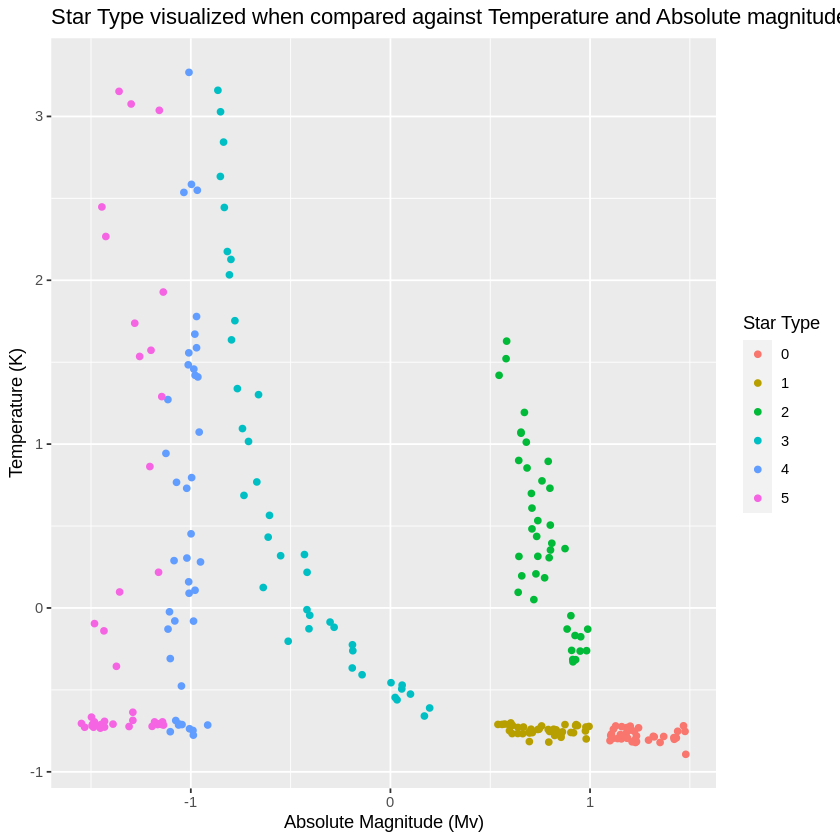

In [20]:
star_recipe <- recipe(Star_type ~ Temperature_K + Radius_ratio + Absolute_magnitude_Mv, data = train_star)|>
                    step_scale(all_predictors())|>
                    step_center(all_predictors())|>
                    prep()
star_scale <- bake(star_recipe, name_star)

options(repr.width.plot = 8, repr.height.plot = 8)
star_recipe_plot <- star_scale|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")
star_recipe_plot

## Discussion of Results

## References

Deepraj Baidya. 2019. Star dataset to predict star types. Retrieved October 24th 2023 from https://www.kaggle.com/datasets/deepu1109/star-dataset/data